# Sameer Gupta


## Section 0: Loading the data

There is no code for you to fill out in this section but please make sure you understand what the code* is doing so you aren't confused in later parts. Basically, this section loads the training, testing, and validation data of the dog images for you.

In [1]:
import numpy as np
import scipy.misc
import cv2
import json
import matplotlib.pyplot as plt
from sklearn.datasets import load_files
from keras import applications
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout, Flatten, Lambda, Dense, Activation
from keras.models import Model, Sequential
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input 
from matplotlib import pyplot
from scipy.misc import toimage
from tqdm import tqdm
from glob import glob
from PIL import Image
from PIL import ImageFile
from skimage.util import random_noise
from skimage import exposure

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Loads the datasets and gets list of dog names (labels). `X_train`, `X_val`, and `X_test` contain lists of image paths to the data.

In [2]:
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

X_train, y_train = load_dataset('dogImages/train')
X_val, y_val = load_dataset('dogImages/valid')
X_test, y_test = load_dataset('dogImages/test')

# List of all dog names
labels = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

`load_image` takes in a string containing a path to an image, loads the image file, converts it into a array matrix, resizes it go be `64x64`, and normalizes all the values to be between 0 and 1.

In [3]:
def load_image(path, size=224):
    #img = Image.open(path.strip())
    img = cv2.imread(path.strip())
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.array(img, np.float32)
    img = scipy.misc.imresize(img, (size, size))
    return img

/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


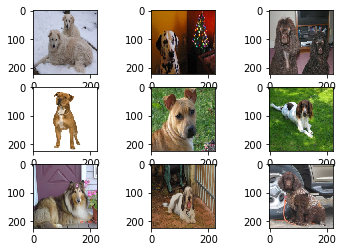

In [4]:
for i in range(0, 9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(load_image(X_train[i]))
# show the plot
pyplot.show()

## Section 1: Data augmentation

In this section we want you to perform some sort of data augmentation as we learnt about in class. This is because we only have roughly 200 examples per label which in deep learning isn't generally enough. Therefore, to improve performance we can use data augmentation as a trick to generate more training examples.

Make sure you try at least **TWO** methods of augmentation. Please explain each augmentation and what it does as well as visualizing at least one example of each augmentation. If you do choose to try more, make sure to incremement `NB_AUGMENTATIONS` by one each time.

If you want to change the size of your image (smaller images train faster), you want to change `IMG_SIZE`.

An example augmentation of flipping the image has already been done for you in `example_augment`.

In [5]:
def example_augment(img):
    augmented_img = np.fliplr(img)
    return augmented_img

**Augmentation Explanation:** FOR YOU TO FILL IN

In [6]:
def augmentation_1(img):
    augmented_img = random_noise(img)
    return augmented_img

**Augmentation Explanation:** FOR YOU TO FILL IN

In [7]:
def augmentation_2(img):
    augmented_img = exposure.adjust_gamma(img, gamma=0.4, gain=0.9)
    return augmented_img

/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


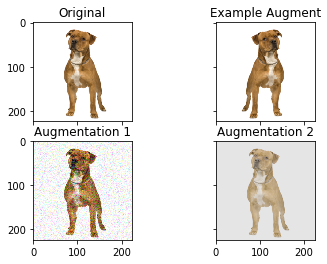

In [8]:
sample_img = load_image(X_train[3])
f, axarr = plt.subplots(2, 2)
axarr[0, 0].imshow(sample_img)
axarr[0, 0].set_title('Original')
axarr[0, 1].imshow(example_augment(sample_img))
axarr[0, 1].set_title('Example Augment')
axarr[1, 0].imshow(augmentation_1(sample_img))
axarr[1, 0].set_title('Augmentation 1')
axarr[1, 1].imshow(augmentation_2(sample_img))
axarr[1, 1].set_title('Augmentation 2')

for ax in axarr.flat:
    ax.label_outer()

In [9]:
NB_AUGMENTATIONS = 3
IMG_SIZE = 224

def batch_generator(images, labels, augment=True, batch_size=32):
    batch_images = []
    batch_labels = []
    sample_count = 0
    
    while True:
        # Shuffle indices to minimize overfitting.
        for i in np.random.permutation(images.shape[0]):

            img_path = images[i]
            label = labels[i]

            img = load_image(img_path, size=IMG_SIZE)
            batch_images.append(img)
            batch_labels.append(label)
            sample_count += 1

            if augment:
                # Perform Augmentation (Flipping the Image)
                img_example_augment = example_augment(img)
                batch_images.append(img_example_augment)
                batch_labels.append(label)
                
                # Perform Augmentation 1
                img_augment_1 = augmentation_1(img)
                batch_images.append(img_augment_1)
                batch_labels.append(label)

                # Perform Augmentation 2
                img_augment_2 = augmentation_2(img)
                batch_images.append(img_augment_2)
                batch_labels.append(label)

            if ((sample_count % batch_size == 0) or (sample_count % len(images) == 0)):
                yield np.array(batch_images), np.array(batch_labels)
                # Reset batch.
                batch_images = []
                batch_labels = []

In [10]:
def path_to_tensor(img_path):
    img = load_image(img_path, 224)
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img) for img in dqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [11]:
model = VGG19(weights='imagenet', include_top=False)

In [12]:
def extract_VGG19(file_paths):
    tensors = paths_to_tensor(file_paths)
    preprocessed_input = preprocess_input(tensors)
    return model.predict(preprocessed_input, batch_size=32)

In [13]:
#train_vgg19 = extract_VGG19(aug_train_X)
#valid_vgg19 = extract_VGG19(X_val)
#test_vgg19 = extract_VGG19(X_test)

train_vgg19 = np.load(open('bottleneck_features_train.npy','rb'))
valid_vgg19 = np.load(open('bottleneck_features_valid.npy','rb'))
test_vgg19 = np.load(open('bottleneck_features_test.npy','rb'))

print("VGG19 shape test", test_vgg19.shape[1:])

#np.save(open('bottleneck_features_test.npy', 'wb'),test_vgg19)


VGG19 shape test (7, 7, 512)


## Section 2: Building the model

In this section you will write all the code to build your Convolutional Neural Network model in Keras. The model should output `NUM_CLASSES` (133 in this case) values which sum up to 1 and are each the probability that the dog is of the respective breed.

**Explanation:** FOR YOU TO FILL IN

In [14]:
from keras.layers import Input
from keras.layers.merge import Concatenate

def input_branch(input_shape=None):
    
    size = int(input_shape[2] / 4)
    
    branch_input = Input(shape=input_shape)
    branch = GlobalAveragePooling2D()(branch_input)
    branch = Dense(size, use_bias=False, kernel_initializer='uniform')(branch)
    branch = BatchNormalization()(branch)
    branch = Activation("relu")(branch)
    return branch, branch_input

vgg19_branch, vgg19_input = input_branch(input_shape=(7, 7, 512))
net = Dropout(0.3)(vgg19_branch)
net = Dense(640, use_bias=False, kernel_initializer='uniform')(net)
net = BatchNormalization()(net)
net = Activation("relu")(net)
net = Dropout(0.3)(net)
net = Dense(133, kernel_initializer='uniform', activation="softmax")(net)

model = Model(inputs=vgg19_input, outputs=[net])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 7, 7, 512)         0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65536     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 640)               81920     
__________

In [15]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

history = model.fit(train_vgg19, y_train, 
          validation_data=(valid_vgg19, y_val),
          epochs=50, batch_size=4, verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/50
6680/6680 [==============================] - 7s 1ms/step - loss: 3.1308 - acc: 0.2490 - val_loss: 1.3952 - val_acc: 0.6084
Epoch 2/50
6680/6680 [==============================] - 6s 955us/step - loss: 2.2457 - acc: 0.3939 - val_loss: 1.1952 - val_acc: 0.6575
Epoch 3/50
6680/6680 [==============================] - 6s 946us/step - loss: 2.0311 - acc: 0.4409 - val_loss: 1.0996 - val_acc: 0.6910
Epoch 4/50
6680/6680 [==============================] - 6s 934us/step - loss: 1.8966 - acc: 0.4790 - val_loss: 1.0186 - val_acc: 0.6994
Epoch 5/50
6680/6680 [==============================] - 7s 1ms/step - loss: 1.8039 - acc: 0.4910 - val_loss: 1.0268 - val_acc: 0.6934
Epoch 6/50
6680/6680 [==============================] - 7s 979us/step - loss: 1.7206 - acc: 0.5296 - val_loss: 0.9479 - val_acc: 0.7329
Epoch 7/50
6680/6680 [==============================] - 6s 960us/step - loss: 1.6730 - acc: 0.5371 - val_loss: 0.9525 - val_acc: 0.7341
Epoch

## Section 3: Training the model

The code to train your model has been done for you already as it is a bit different than before due to the batch generator. Notice how we set `augment` to false for the validation generator. It is important never to augment your validation nor testing data since that can bias (inflate or deflate) the accuracy scores. The code also saves your models weights in the end which we can use for testing later on so we don't have to retrain it entirely.

In [16]:
model.save_weights('modelDog.h5', True)
with open('modelDog.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)

## Section 4: Evaluation

In this section you will compute the accuracy of your model on the test data from Section 0. Make sure you very clearly have a cell that outputs and prints the percentage accuracy of your model. You will also include any code used to analyze the results here.

A confusion matrix would be nice but since there are so many classes it will be hard to cleanly visualize. Instead f1, precision, and recall scores for each class would be cleaner to read.

**Explanation:** FOR YOU TO FILL IN

In [22]:
y_pred = model.predict(test_vgg19)
y_test_class = np.argmax(y_test,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

score = model.evaluate(test_vgg19,y_test,verbose=False)
print("Accurary: %.4f%%" %(score[1]*100))

Accurary: 78.9474%


In [ ]:
print(history.history.keys())

In [ ]:
# Summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['acc'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [ ]:
# Summarize history for accuracy
#plt.plot(history.history['loss'])
plt.plot(history.history['acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [23]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_test_class,y_pred_class))

             precision    recall  f1-score   support

          0       1.00      0.88      0.93         8
          1       0.71      0.62      0.67         8
          2       0.56      0.83      0.67         6
          3       1.00      0.88      0.93         8
          4       0.91      1.00      0.95        10
          5       1.00      1.00      1.00         8
          6       0.55      0.86      0.67         7
          7       0.89      1.00      0.94         8
          8       0.40      0.50      0.44         4
          9       1.00      0.83      0.91         6
         10       1.00      0.89      0.94         9
         11       1.00      0.56      0.71         9
         12       1.00      0.50      0.67         6
         13       1.00      1.00      1.00         9
         14       1.00      0.90      0.95        10
         15       1.00      0.38      0.55         8
         16       0.73      1.00      0.84         8
         17       0.71      0.71      0.71   

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


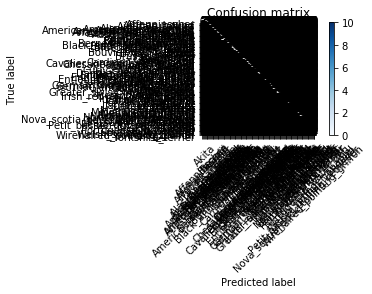

In [27]:
cnf_matrix = confusion_matrix(y_test_class,y_pred_class)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels, title='Confusion matrix')

\* Project Code inspired and taken from Udacity's AI Nanodegress https://github.com/mahavird/dog-project. All credit for the helper methods to load the dataset goes to Udacity.